In [1]:
import time
import umap
import prince
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
data = pd.read_csv('data/cc_general.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
data.drop('CUST_ID', axis=1, inplace=True)

In [4]:
data.dropna(inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8636 non-null   float64
 1   BALANCE_FREQUENCY                 8636 non-null   float64
 2   PURCHASES                         8636 non-null   float64
 3   ONEOFF_PURCHASES                  8636 non-null   float64
 4   INSTALLMENTS_PURCHASES            8636 non-null   float64
 5   CASH_ADVANCE                      8636 non-null   float64
 6   PURCHASES_FREQUENCY               8636 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8636 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8636 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8636 non-null   float64
 10  CASH_ADVANCE_TRX                  8636 non-null   int64  
 11  PURCHASES_TRX                     8636 non-null   int64  
 12  CREDIT

In [6]:
# Find closely correlated features and remove them
num_corr = data.corr()
features = list(num_corr.columns)
print('original feature length: {}'.format(len(features)))

# Loops to check correlation under diagonal (where columns correlate with themselves)
for x in range(0, len(num_corr.columns), 1):
    col =  abs(num_corr.iloc[(x+1):, x]).sort_values(ascending=False)
    for y in range(len(col)):
        if col[y] > .75:
            if col.index[y] in features:
                features.remove(col.index[y])
print('new feature length: {}'.format(len(features)))

original feature length: 17
new feature length: 14


In [7]:
# replace data with updatad features list
data = data[features]
df = data.drop("TENURE", axis=1)
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,95.40,0.000000,0.166667,0.000000,0.00,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,6442.945483,0.000000,0.000000,0.25,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,0.00,0.000000,1.000000,1.000000,0.00,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,0.00,0.000000,0.083333,0.083333,0.00,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,1333.28,0.000000,0.666667,0.000000,0.00,8,1800.0,1400.057770,2407.246035,0.000000,12


In [8]:
scale = StandardScaler()
scaled = scale.fit_transform(data)

## DBSCAN for initial clustering

In [45]:
# Function will rank best clustering parameters using adjusted_rand_score as the scoring metric
def best_dbscan_cluster(scaled):
    
    # Initialize values
    range_list = np.arange(2, 8, 1)
    best = 0
    first_score = {'eps': 0, 'min_samps': 0, 'silhouette_score': 0, 'clusters': 0}
    second_score = {}
    labels1 = []
    
    # Loop through hyperparameters and save best scoring combinations
    for eps in range_list:
        
        for min_samp in range_list:
            dbscan = DBSCAN(eps=eps, min_samples=min_samp, n_jobs=8)
            dbscan = dbscan.fit(scaled)
            clusters = dbscan.fit_predict(scaled)
            sil_score = silhouette_score(scaled, clusters, metric='euclidean')
            
            
            if sil_score > best:
                # update dictionary of second best silouette score with copy of previous best parameters
                second_score['eps'] = first_score['eps']
                second_score['min_samps'] = first_score['min_samps']
                second_score['silhouette_score'] = first_score['silhouette_score']
                second_score['clusters'] = first_score['clusters']
                
                # update dictionary with current best parameters
                first_score['eps'] = eps
                first_score['min_samps'] = min_samp
                first_score['silhouette_score'] = sil_score
                first_score['clusters'] = len(np.unique(clusters))
                
                # update second set of labels with previous best labels and update the first list with the recent best labels
                labels2 = labels1
                labels1 = dbscan.labels_
                
                best = sil_score
                            
    return first_score, second_score, labels1, labels2

In [10]:
# Run function with scaled data. Display the dictionary of results for initial idea of cluster amount
time_start = time.time()
dbscan_score1, dbscan_score2, dbscan_labels1, dbscan_labels2 = best_dbscan_cluster(scaled)
print(dbscan_score1)
print(dbscan_score2)
print('Scans complete! Time elapsed: {:.2f} seconds'.format(time.time()-time_start))

{'eps': 6, 'min_samps': 4, 'silhouette_score': 0.7927669531483723, 'clusters': 2}
{'eps': 6, 'min_samps': 3, 'silhouette_score': 0.7791891337267771, 'clusters': 3}
Scans complete! Time elapsed: 157.45 seconds


#### Use dimensionality reduction to map points in 2D feature space

In [12]:
palette = ['r', 'b', 'y', 'g', 'violet', 'orange', 'indigo']

def get_colors(labels, palette):
    color_list = []
    for label in labels:
        color_list.append(palette[label + 1])
    return color_list

In [13]:
pca = PCA(n_components=2)
pca_2components = pca.fit_transform(scaled)

In [14]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.2,
                      metric='correlation').fit_transform(scaled)

In [15]:
def dualmaps(pca_components, umap_components, score, labels, palette):
    p = palette[:score['clusters']]
    fig= plt.subplots(figsize=(8,6))
    plt.subplot(1,2,1)
    plt.title('UMAP 2D with {} DBSCAN clusters'.format(dbscan_score1['clusters']))
    sns.scatterplot(x=umap_components[:, 0], y=umap_components[:, 1], hue=labels, palette=p)

    plt.subplot(1,2,2)
    plt.title('PCA 2D with {} DBSCAN clusters'.format(dbscan_score1['clusters']))
    sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels, palette=p)

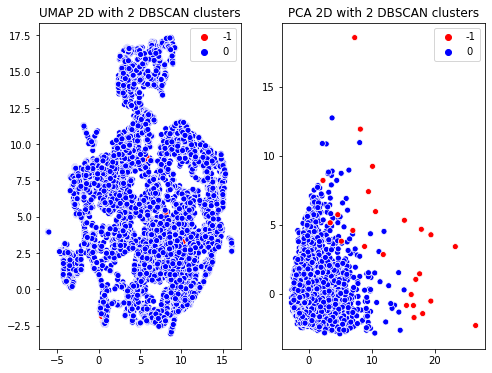

In [16]:
# Plot results using the cluster labels from the best dbscan silhouette score to dictate color
dualmaps(pca_2components, umap_results, dbscan_score1, dbscan_labels1, palette)

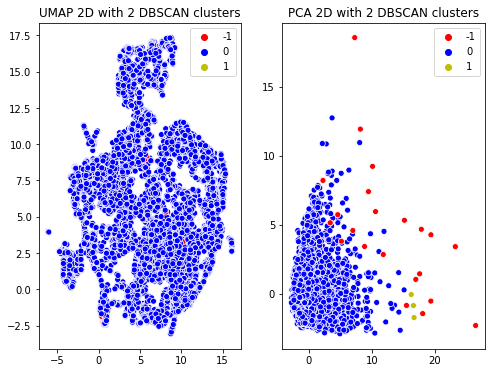

In [17]:
# Plot results using the cluster labels from the next best dbscan silhouette score to dictate color
dualmaps(pca_2components, umap_results, dbscan_score2, dbscan_labels2, palette)

#### Use dimensionality reduction to map points in 3D feature space

In [20]:
pca = PCA(n_components=3)
pca_3components = pca.fit_transform(scaled)

In [21]:
def graph3dPCA(color_list, components):
    fig = plt.figure(figsize=(9,6))
    ax = Axes3D(fig)


    x = components[:, 0]
    y = components[:, 1]
    z = components[:, 2]
    ax.scatter(x, y, z, s=45, alpha=.6, edgecolors='black', c=color_list)

    ax.set_xlabel('PCA Component: 1')
    ax.set_ylabel('PCA Component: 2')
    ax.set_zlabel('PCA Component: 3')

    plt.show()

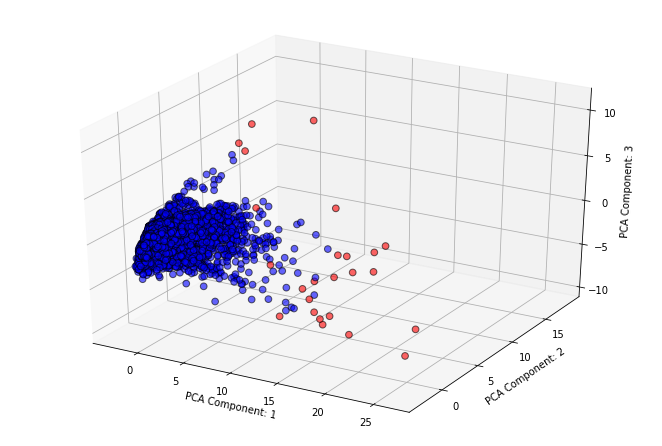

In [22]:
# Coloring based on labels produced from best scoring dbscan
best_dbscan_colors = get_colors(dbscan_labels1, palette)
graph3dPCA(best_dbscan_colors, pca_3components)

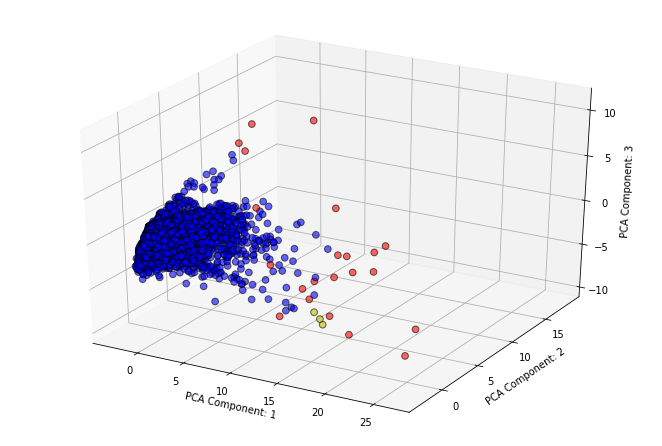

In [23]:
# Coloring based on second best scoring dbscan
next_dbscan_colors = get_colors(dbscan_labels2, palette)
graph3dPCA(next_dbscan_colors, pca_3components)

## Heirarachical Agglomerative Clustering model

In [55]:
# Function will rank best clustering parameters using adjusted_rand_score as the scoring metric
def best_hierarchical_cluster(scaled):
    
    # Initialize values
    link_list = ['complete', 'average', 'ward']
    affinity_list = ['cosine', 'manhattan', 'euclidean']
    best = 0
    first_score = {'link': 0, 'affinity': 0, 'silhouette_score': 0, 'clusters': 0}
    second_score = {}
    labels1 = []
    
    # Loop through hyperparameters and save best scoring combinations
    for link in link_list:
        
        for af in affinity_list:
            if link != 'ward':
                agg_cluster = AgglomerativeClustering(linkage=link, affinity=af)
            else:
                agg_cluster = AgglomerativeClustering(linkage=link, affinity='euclidean')
            agg_cluster = agg_cluster.fit(scaled)
            clusters = agg_cluster.fit_predict(scaled)
            sil_score = silhouette_score(scaled, clusters, metric='euclidean')
            
            
            if sil_score > best:
                # update dictionary of second best silouette score with copy of previous best parameters
                second_score['link'] = first_score['link']
                second_score['affinity'] = first_score['affinity']
                second_score['silhouette_score'] = first_score['silhouette_score']
                second_score['clusters'] = first_score['clusters']
                
                # update dictionary with current best parameters
                first_score['link'] = link
                first_score['affinity'] = af
                first_score['silhouette_score'] = sil_score
                first_score['clusters'] = len(np.unique(clusters))
                
                # update second set of labels with previous best labels and update the first list with the recent best labels
                labels2 = labels1
                labels1 = agg_cluster.labels_
                
                best = sil_score
                            
    return first_score, second_score, labels1, labels2

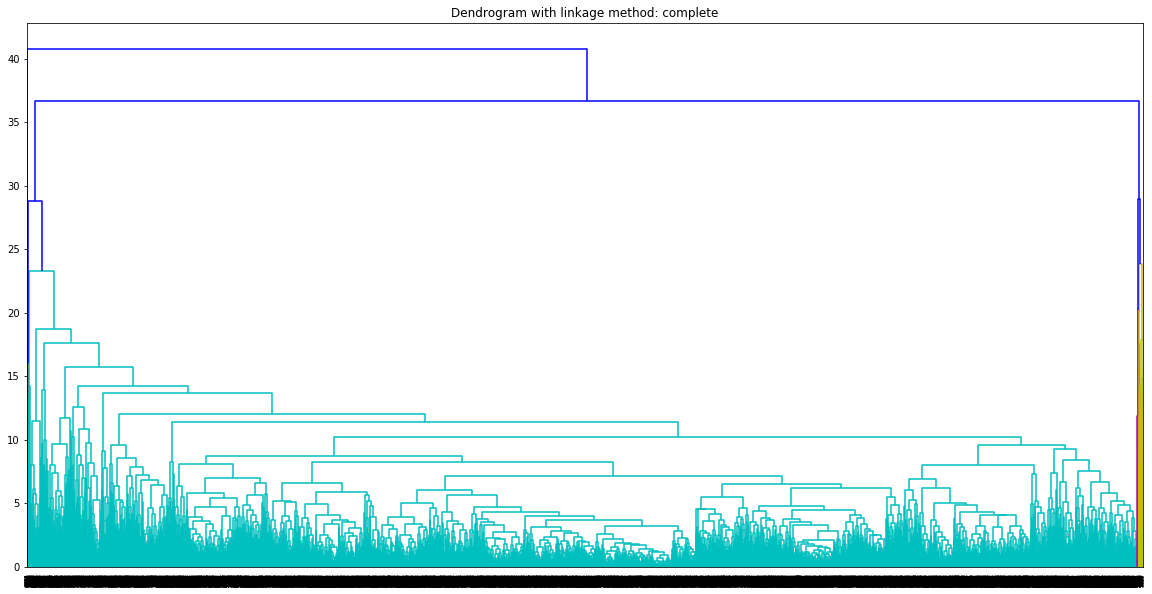

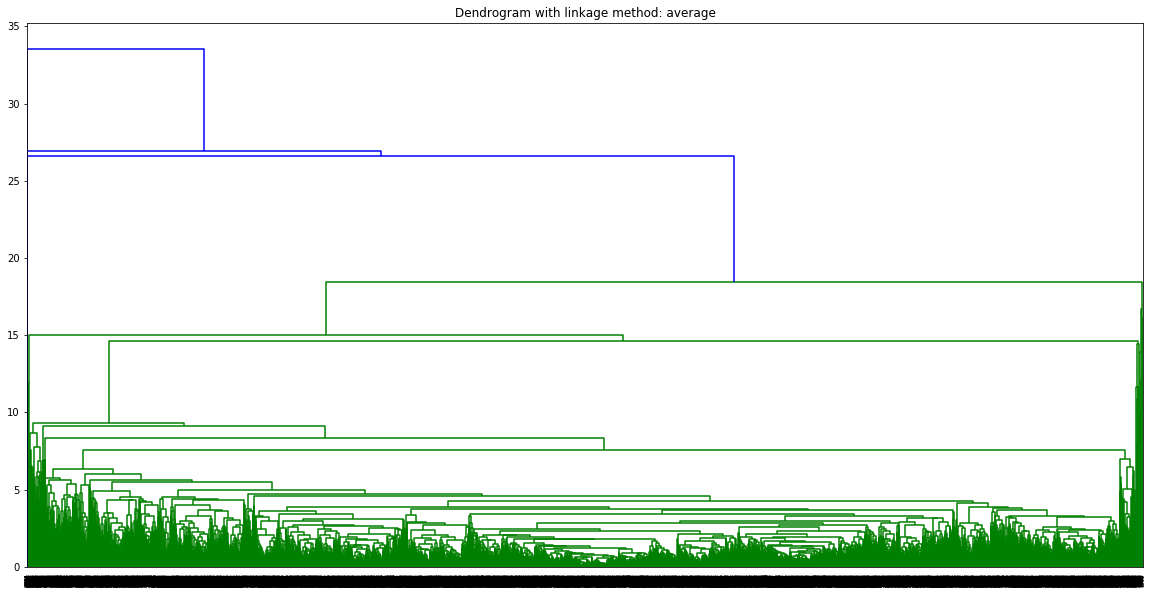

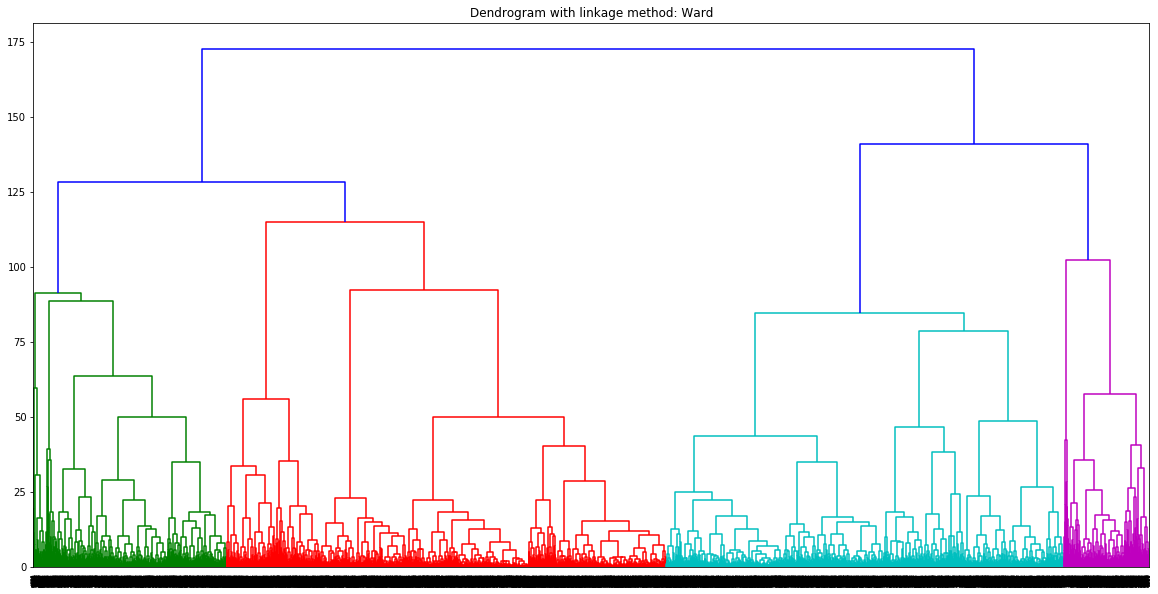

In [49]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(scaled, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(scaled, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(scaled, method='ward'))
plt.show()

In [56]:
agg_score1, agg_score2, agg_labels1, agg_labels2 = best_hierarchical_cluster(scaled)

In [57]:
print(agg_score1)
print(agg_score2)

{'link': 'average', 'affinity': 'manhattan', 'silhouette_score': 0.8613517558587538, 'clusters': 2}
{'link': 'complete', 'affinity': 'euclidean', 'silhouette_score': 0.7970865270085067, 'clusters': 2}


Even though the Ward linkage method produced the most even groups, those groupings did not produce a silhouette score high enough to replace the best two scoring linkage methods.

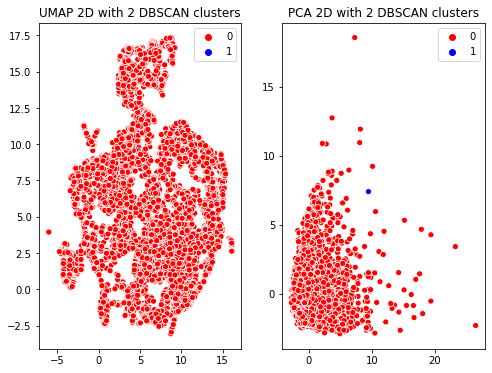

In [58]:
# Plot results using the cluster labels from the best gmm score to dictate color
dualmaps(pca_2components, umap_results, agg_score1, agg_labels1, palette)

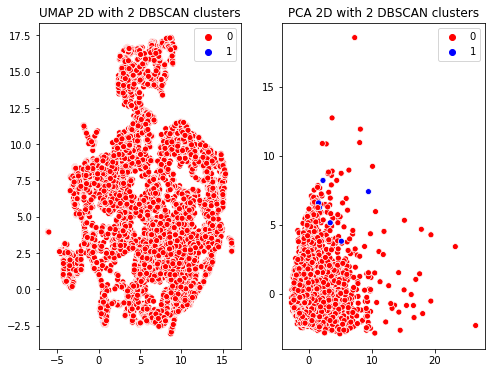

In [59]:
dualmaps(pca_2components, umap_results, agg_score2, agg_labels2, palette)

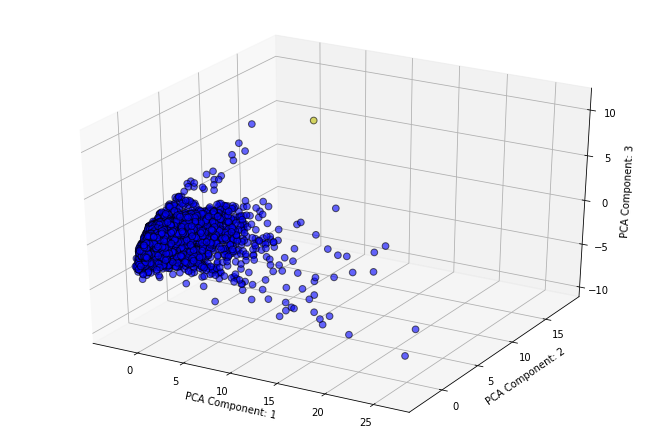

In [60]:
# Coloring based on labels produced from best scoring Agglomerative model
best_agg_colors = get_colors(agg_labels1, palette)
graph3dPCA(best_agg_colors, pca_3components)

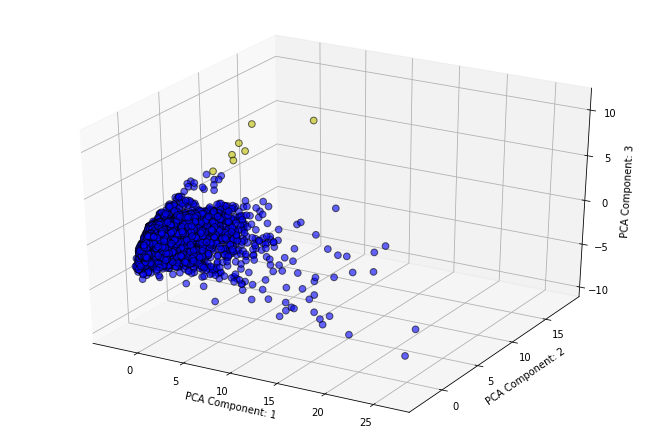

In [61]:
# Coloring based on labels produced from second best scoring Agglomerative model
best_agg_colors = get_colors(agg_labels2, palette)
graph3dPCA(best_agg_colors, pca_3components)

## Gaussian Mixture modeling for additional clustering

In [84]:
# Function will rank best clustering parameters using adjusted_rand_score as the scoring metric
def best_gmm_cluster(scaled):
    
    # Initialize values
    covariance = ['full', 'tied', 'diag', 'spherical']
    best = 0
    first_score = {'covariance':0, 'clusters':0, 'silhouette_score':0, 'weights':0}
    second_score = {}
    labels1 = []
    
    clust_list = np.arange(3,18,1)
    
    # Loop through hyperparameters and save best scoring combinations
    for cov in covariance:
        for clu in clust_list:
            gmm = GaussianMixture(n_components=clu, covariance_type=cov, max_iter=200).fit(scaled)
            clusters = gmm.fit_predict(scaled)
            sil_score = silhouette_score(scaled, clusters, metric='euclidean')
                
            if sil_score > best:
                # update dictionary of second best silouette score with copy of previous best parameters
                second_score['covariance'] = first_score['covariance']
                second_score['clusters'] = first_score['clusters']
                second_score['silhouette_score'] = first_score['silhouette_score']
                second_score['weights'] = first_score['weights']
                
                # update dictionary with current best parameters
                first_score['covariance'] = cov
                first_score['clusters'] = clu
                first_score['silhouette_score'] = sil_score
                first_score['weights'] = gmm.weights_
                
                # update second set of labels with previous best labels and update the first list with the recent best labels
                labels2 = labels1
                labels1 = clusters
                
                best = sil_score
            
    return first_score, second_score, labels1, labels2                

In [85]:
# plug data into gmm using estimated best clusters from dbscan as initial list
time_start = time.time()
gmm_score1, gmm_score2, gmm_labels1, gmm_labels2 = best_gmm_cluster(scaled)
print(gmm_score1)
print(gmm_score2)
print('Scans complete! Time elapsed: {:.2f} seconds'.format(time.time()-time_start))

{'covariance': 'tied', 'clusters': 3, 'silhouette_score': 0.2466615389011785, 'weights': array([0.02638487, 0.80223566, 0.17137947])}
{'covariance': 'full', 'clusters': 3, 'silhouette_score': 0.09119146635813641, 'weights': array([0.26092163, 0.14962443, 0.58945394])}
Scans complete! Time elapsed: 113.68 seconds


#### Use dimensionality reduction to map points in 2D feature space

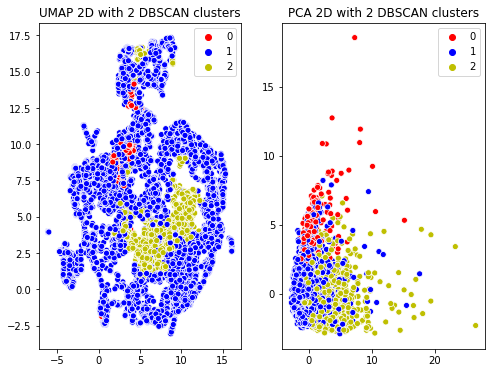

In [86]:
# Plot results using the cluster labels from the best gmm score to dictate color
dualmaps(pca_2components, umap_results, gmm_score1, gmm_labels1, palette)

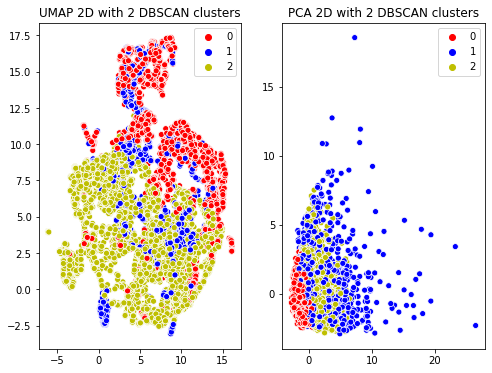

In [87]:
# Plot results using the cluster labels from the next best gmm silhouette score to dictate color
dualmaps(pca_2components, umap_results, gmm_score2, gmm_labels2, palette)

#### Use dimensionality reduction to map points in 3D feature space

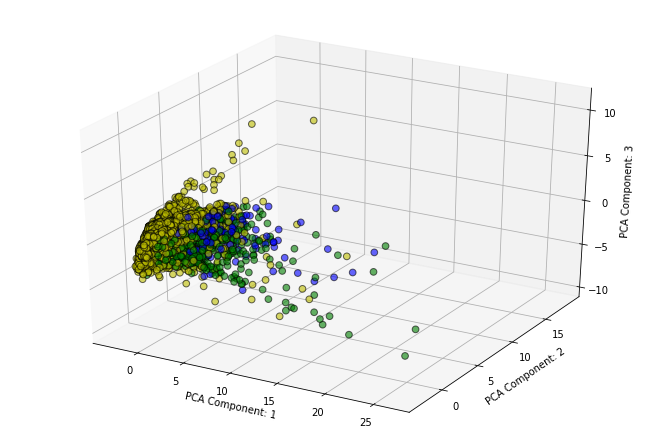

In [88]:
# Coloring based on labels produced from best scoring gmm
best_gmm_colors = get_colors(gmm_labels1, palette)
graph3dPCA(best_gmm_colors, pca_3components)

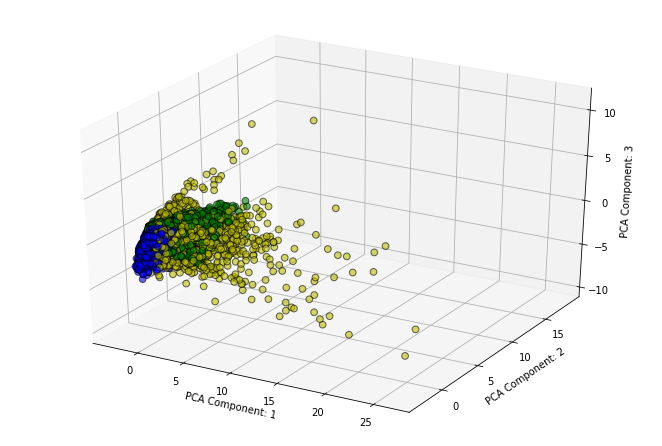

In [89]:
# Coloring based on second best scoring gmm
next_gmm_colors = get_colors(gmm_labels2, palette)
graph3dPCA(next_gmm_colors, pca_3components)

### Summarizing the Categories

In [90]:
dbscan_clusters1 = pd.concat([data, pd.DataFrame({'cluster labels': dbscan_labels1})], axis=1)
dbscan_clusters2 = pd.concat([data, pd.DataFrame({'cluster labels': dbscan_labels2})], axis=1)
gmm_clusters1 = pd.concat([data, pd.DataFrame({'cluster labels': gmm_labels1})], axis=1)
gmm_clusters2 = pd.concat([data, pd.DataFrame({'cluster labels': gmm_labels2})], axis=1)

DBSCAN's best scoring cluster was good at classifying outliers, so we can use it to see where the outliers differ from the main data

In [91]:
outliers = dbscan_clusters1[dbscan_clusters1['cluster labels'] == -1]
len(outliers)

25

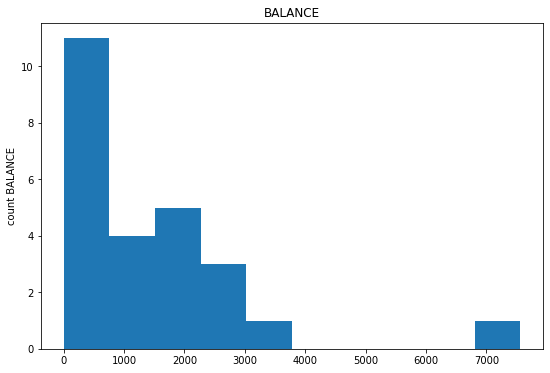

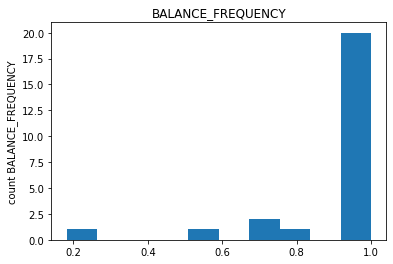

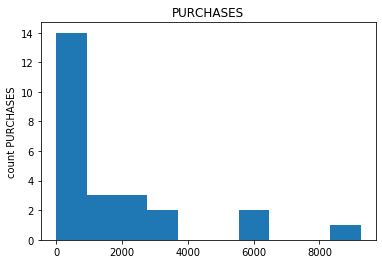

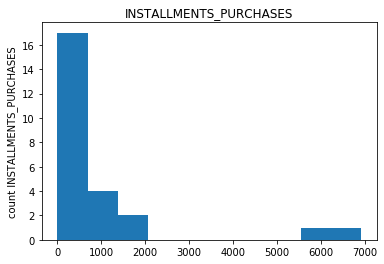

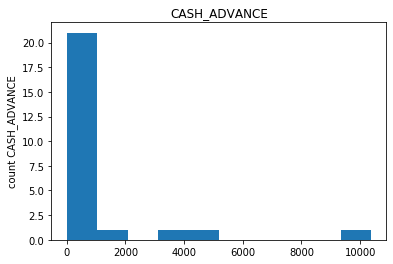

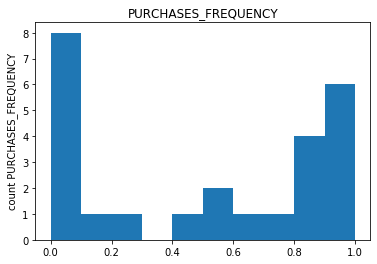

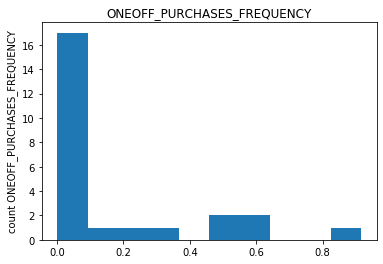

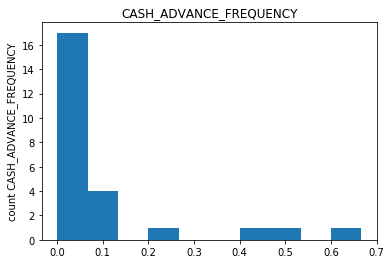

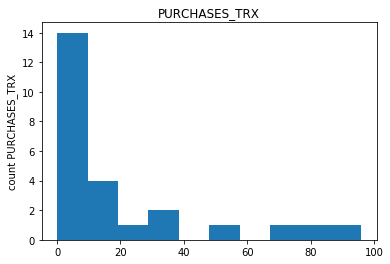

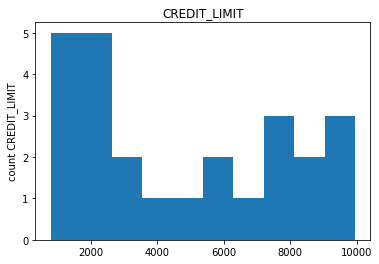

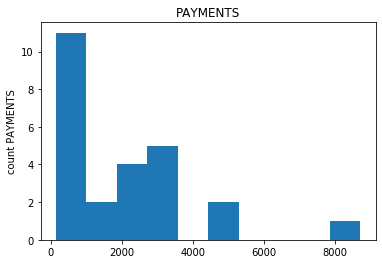

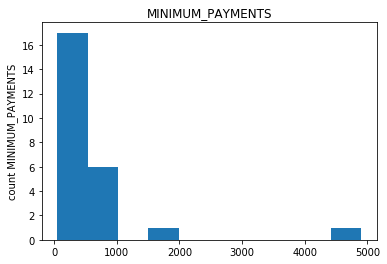

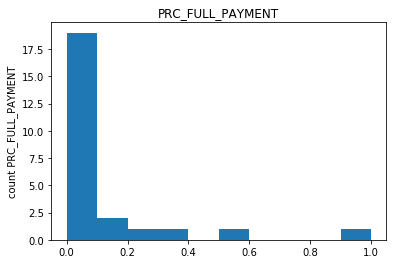

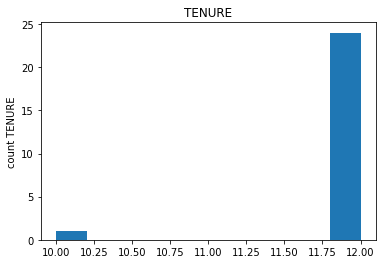

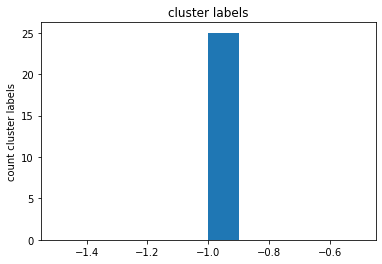

In [92]:
fig = plt.subplots(figsize=(9, 6))
for c in outliers:
    plt.hist(outliers[c])
    plt.ylabel('count {}'.format(c))
    plt.title(c)
    plt.show()

These grpahs represent the distribution of people marked as outliers. As you would expect from a distribution of outliers, the trend in each category is that the bulk of the datapoints reside on the extremes of the graph.

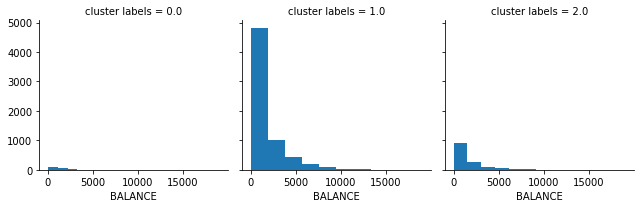

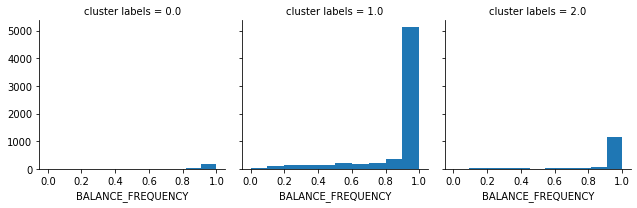

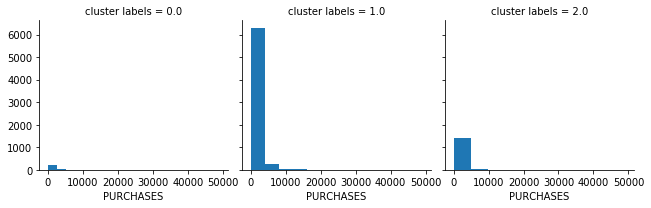

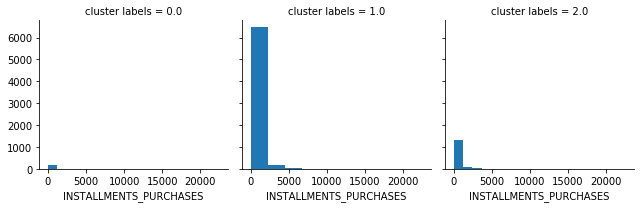

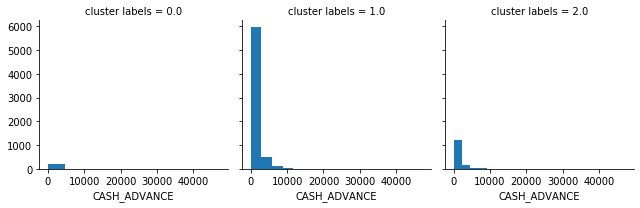

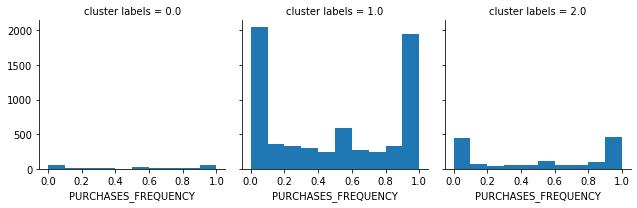

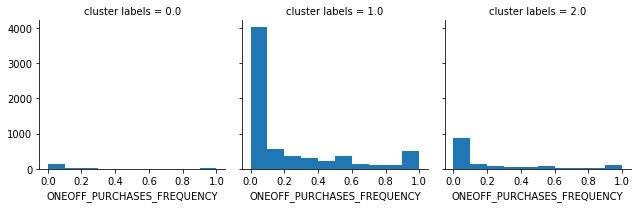

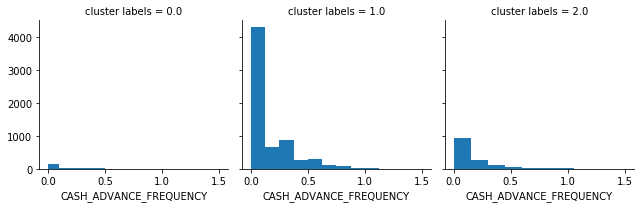

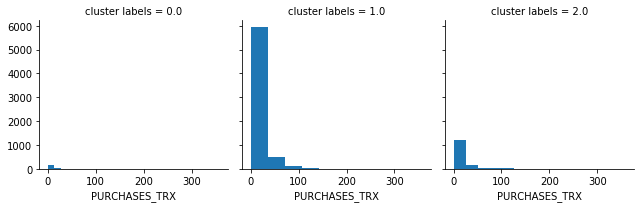

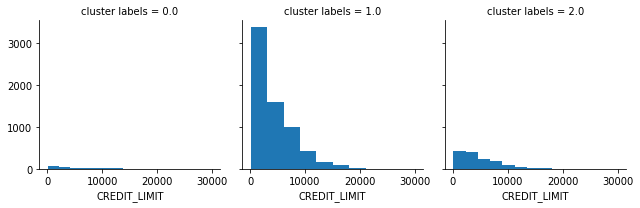

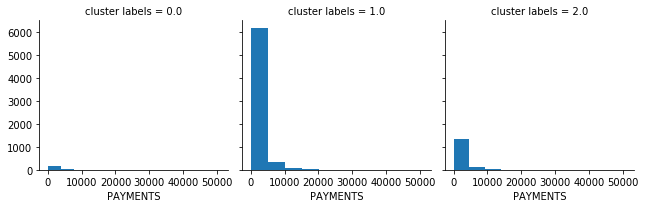

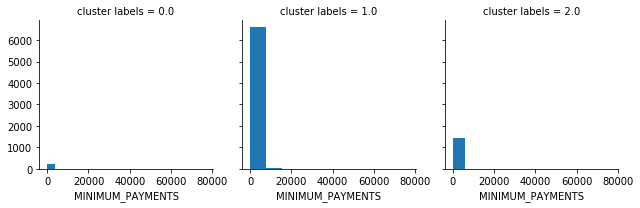

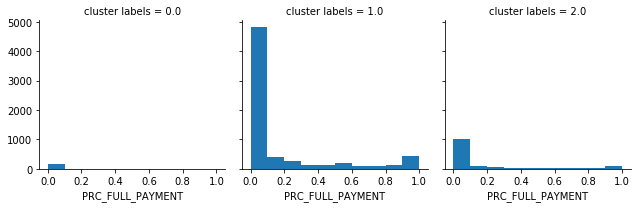

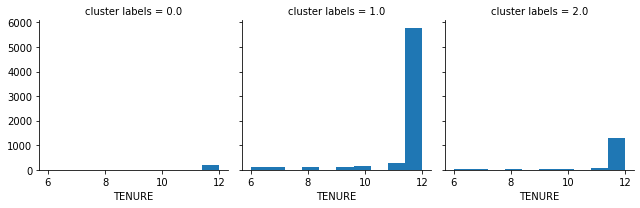

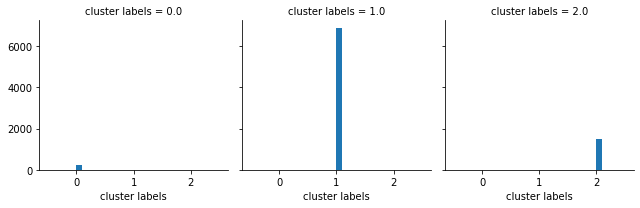

In [93]:
for c in gmm_clusters1:
    grid= sns.FacetGrid(gmm_clusters1, col='cluster labels')
    grid.map(plt.hist, c)

The above group behaviors are summarized as follows:

1) Makes low payments, has poor credit, takes out small loans, no cash advancements, low credit tenure

2) Bulk of customers are in this group. Credit ranges from both the lowest and highest ends of the spectrum, your typical spender or average customer.

3) Very closely follows the trends of the average customer, but results skewed slightly on the more positive side. Might contain higher members of wealthy or stable income credit card holders.

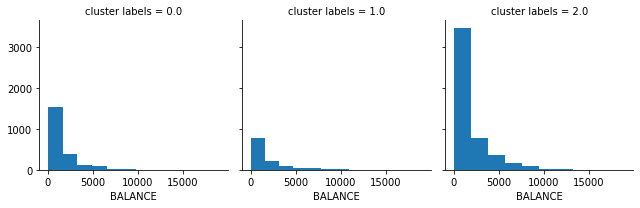

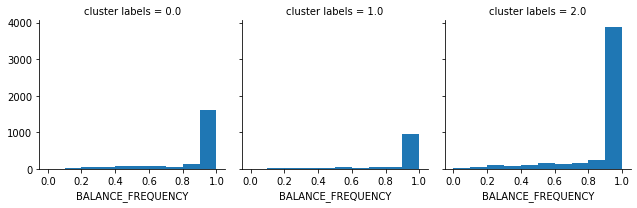

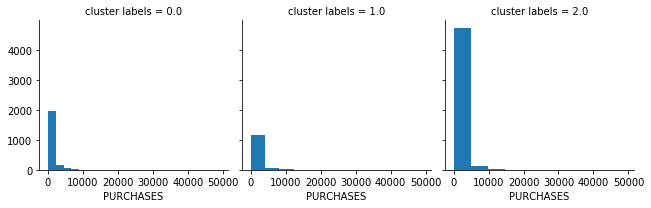

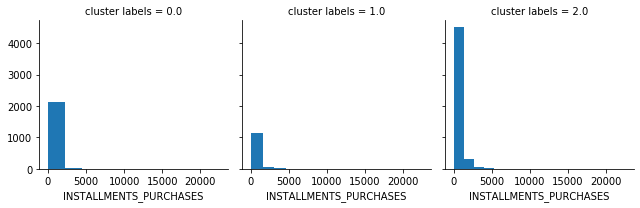

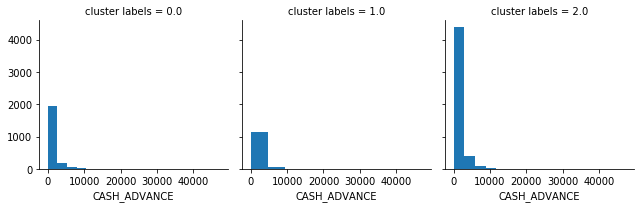

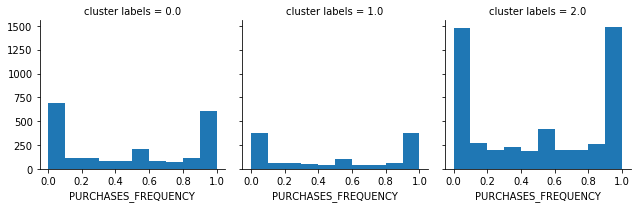

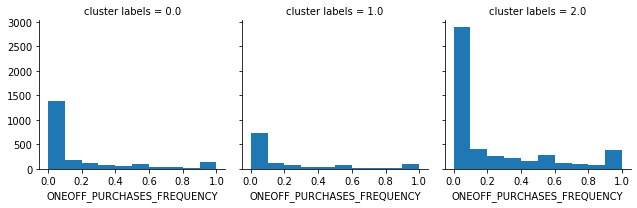

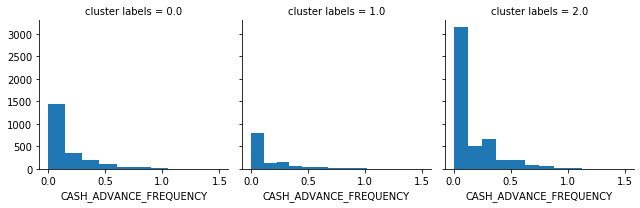

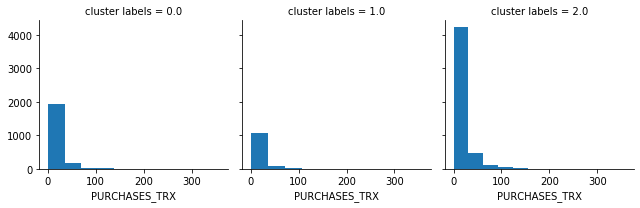

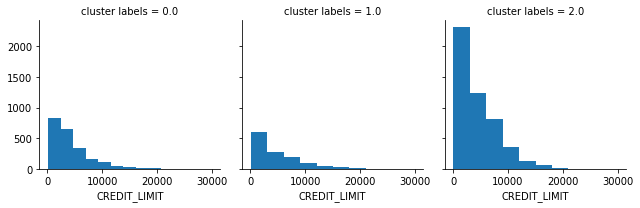

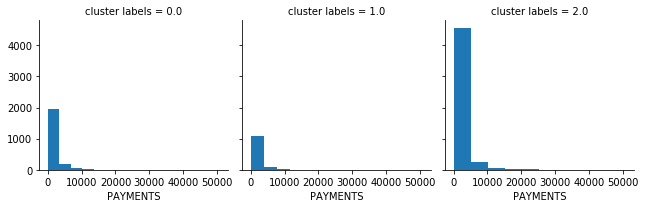

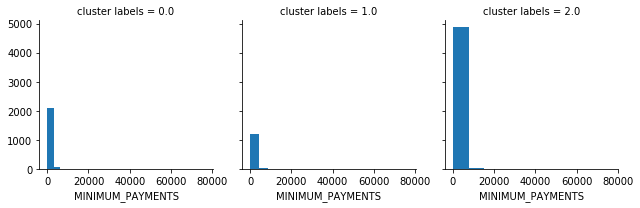

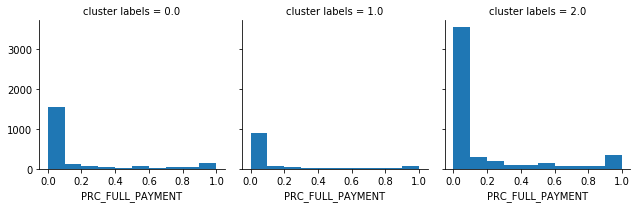

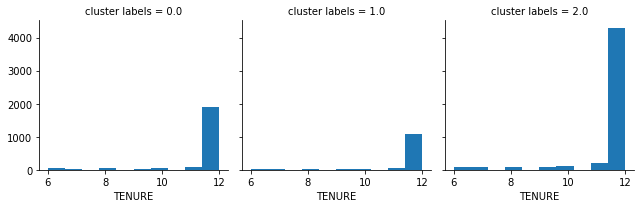

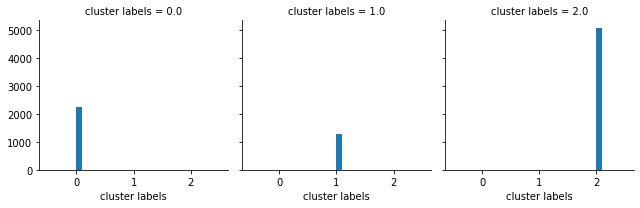

In [94]:
for c in gmm_clusters2:
    grid= sns.FacetGrid(gmm_clusters2, col='cluster labels')
    grid.map(plt.hist, c)

From the next best gaussian model:

1) This is probably your less financially savvy group. They mkae more one time buys which may indicate a level of impulsive spending; they update their bank balance frequently, but often still doesn't have much to spend.

2) This grouping is cautious of their funds. They are more likely to update their funds often, have a habit of making reasonable payments, have a decent instance of loan repayment, and an average credit score.

3) This is the main group containing the bigger range of customers. It represents the average customer.


------------------------------------
The second best silhouette scoring from DBSCAN didn't provide much of a difference than when using it to classify just the outliers, so it wasn't included in the overall analysis. Similar reasons are why the two best scoring agglomaerative clusters aren't analyzed: the plots either didnt explain enough fine detail or was picked too sparse points to be a group. There wasn't enough of a difference between groupings to include in the analysis.